# HomeSite Quote Conversion A Fastai Tabular Approach
> We used Fastai Tabular libary and WalkWithFastai functions to build our Deep Learning model for HomeSite Quote Conversion competition in Kaggle. The techniques used in this notebook include Permutation Importance Analysis, Model Ensembling, Bayesian Optimisation for hyperparameter tuning and Entity Embddings.

- toc: true to apply his techniques for permutation importance and ensemble learning to the Homesite Competition problem set
- badges: true
- comments: true
- categories: [kaggle, fastai]
- author: Nissan Dookeran and Tracy Dinh
- image: images/chart-preview.png

## Introduction

  As Jeremy Howard mentioned in one of his lessons about tabular data, there are 2 main methods in modelling tabular or structured data: 
  
1.   **Ensembles of Decision Trees (Random Forest or Gradient Boosting Machine)**
2.   **Multilayered Neural Networks**

The former method is far more popular and usually our first approach when analysing new tabular dataset. This is why he was focusing more on how to train and improve performance of a random forest model but not going too deep into training a deep learning model

However, Fastai itself has a lot of great function to train and improve performance of tabular data model and this is what we want to explore in this article. 

Most of the techniques and codes in this notebooks were borrowed from Walk with Fastai from Zack Mueller so please check out his official website: https://walkwithfastai.com/




When you think about improving your model’s performance, some of the methods that you will definitely consider include: 


-  **Feature Engineering**
-  **Hyperparameter Tuning**
-  **Combining Models**

This is also exactly what we are going to discuss in this article. 

1. **Basic Deep Learning Model for Tabular Data**
2. **Permutation Analysis to identify Important Features**
3. **Model Ensembling**
4. **Hyperparameter Tuning with Bayesian Optimisation**
5. **Entity Embeddings**


## Setup

In [ ]:
!pip install -Uqq fastai fastbook
import fastbook
fastbook.setup_book()

In [ ]:
from fastai.tabular.all import *
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

from sklearn.metrics import roc_auc_score


## Download Data

Download your Kaggle KPI, store it in a folder in Google Drive and run the below codes

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/gdrive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Assign the folder where to want to store the data to path

In [ ]:
path = Path('/content/gdrive/MyDrive/Kaggle/' + 'data/homesite-quote')
path.mkdir(parents=True, exist_ok=True)
path

Path('/content/gdrive/MyDrive/Kaggle/data/homesite-quote')

Download your data into that folder

In [ ]:
!kaggle competitions download -c homesite-quote-conversion -p /content/gdrive/MyDrive/Kaggle/data/homesite-quote


Unzip your data

In [ ]:
! unzip -q -n '{path}/train.csv.zip' -d '{path}'
! unzip -q -n '{path}/test.csv.zip' -d '{path}'


Import data and store it as a dataframe 

In [ ]:
df = pd.read_csv(path/'train.csv', low_memory=False, parse_dates=['Original_Quote_Date'])
test_df=pd.read_csv(path/'test.csv', low_memory=False, parse_dates=['Original_Quote_Date'])

## EDA

In [ ]:
df_train = df.copy()
df_test = test_df.copy()


In [ ]:
df_train.QuoteConversion_Flag = df_train.QuoteConversion_Flag.astype(dtype='boolean')

In [ ]:
df_train = df_train.set_index('QuoteNumber')
df_test = df_test.set_index('QuoteNumber')


In [ ]:
df_train = add_datepart(df_train, 'Original_Quote_Date')
df_test = add_datepart(df_test, 'Original_Quote_Date')

In [ ]:
y_names = 'QuoteConversion_Flag'
cont_names, cat_names = cont_cat_split(df_train, dep_var=y_names)
len(cont_names), len(cat_names)

(155, 154)

## Deep Learning Model

Set up hyperparameters

In [ ]:
random_seed = 42 
bs = 4096
val_bs = 512
test_size = 0.3
epochs = 5
lr = 1e-2
wd=0.002
layers = [10000,500]
dropout = [0.001, 0.01]
y_block=CategoryBlock()
emb_dropout=0.02
set_seed(42)
roc_auc_binary = RocAucBinary()

In [ ]:
procs = [Categorify, FillMissing, Normalize]
splits = TrainTestSplitter(test_size=test_size, stratify=df_train[y_names])(df_train)

In [ ]:
to = TabularPandas(df=df_train, procs=procs, cat_names=cat_names, 
                   cont_names=cont_names, y_names=y_names,splits=splits,
                  y_block=y_block)
dls = to.dataloaders(bs=bs, val_bs=val_bs, layers=layers, embed_ps=emb_dropout, ps=dropout)
dls.valid.show_batch()

,Field6,Field10,Field12,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,SalesField3,SalesField4,SalesField5,SalesField7,SalesField9,SalesField10,SalesField11,SalesField13,SalesField14,SalesField15,PersonalField1,PersonalField2,PersonalField5,PersonalField6,PersonalField7,PersonalField8,PersonalField9,PersonalField11,PersonalField12,PersonalField13,PersonalField16,PersonalField17,PersonalField18,PersonalField19,PersonalField22,PersonalField23,PersonalField24,PersonalField25,PersonalField26,PersonalField27,PersonalField28,PersonalField29,PersonalField30,PersonalField31,PersonalField32,PersonalField33,PersonalField34,PersonalField35,PersonalField36,PersonalField37,PersonalField38,PersonalField39,PersonalField40,PersonalField41,PersonalField42,PersonalField43,PersonalField44,PersonalField45,PersonalField46,PersonalField47,PersonalField48,PersonalField49,PersonalField50,PersonalField51,PersonalField52,PersonalField53,PersonalField54,PersonalField55,PersonalField56,PersonalField57,PersonalField58,PersonalField59,PersonalField60,PersonalField61,PersonalField62,PersonalField63,PersonalField64,PersonalField65,PersonalField66,PersonalField67,PersonalField68,PersonalField69,PersonalField70,PersonalField71,PersonalField72,PersonalField73,PersonalField74,PersonalField75,PersonalField76,PersonalField77,PersonalField78,PersonalField79,PersonalField80,PersonalField81,PersonalField82,PersonalField83,PropertyField2A,PropertyField3,PropertyField4,PropertyField5,PropertyField6,PropertyField7,PropertyField8,PropertyField9,PropertyField10,PropertyField11A,PropertyField11B,PropertyField12,PropertyField13,PropertyField14,PropertyField15,PropertyField17,PropertyField18,PropertyField19,PropertyField20,PropertyField22,PropertyField23,PropertyField27,PropertyField28,PropertyField30,PropertyField31,PropertyField32,PropertyField33,PropertyField34,PropertyField35,PropertyField36,PropertyField37,PropertyField38,GeographicField5A,GeographicField5B,GeographicField10A,GeographicField10B,GeographicField14A,GeographicField14B,GeographicField18A,GeographicField21A,GeographicField22A,GeographicField22B,GeographicField23A,GeographicField56A,GeographicField60A,GeographicField61A,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64,Original_Quote_Year,Original_Quote_Month,Original_Quote_Dayofweek,Original_Quote_Is_month_end,Original_Quote_Is_month_start,Original_Quote_Is_quarter_end,Original_Quote_Is_quarter_start,Original_Quote_Is_year_end,Original_Quote_Is_year_start,PersonalField84_na,PropertyField29_na,Field7,Field8,Field9,Field11,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField6,SalesField8,SalesField12,PersonalField4A,PersonalField4B,PersonalField10A,PersonalField10B,PersonalField14,PersonalField15,PersonalField84,PropertyField1A,PropertyField1B,PropertyField2B,PropertyField16A,PropertyField16B,PropertyField21A,PropertyField21B,PropertyField24A,PropertyField24B,PropertyField25,PropertyField26A,PropertyField26B,PropertyField29,PropertyField39A,PropertyField39B,GeographicField1A,GeographicField1B,GeographicField2A,GeographicField2B,GeographicField3A,GeographicField3B,GeographicField4A,GeographicField4B,GeographicField6A,GeographicField6B,GeographicField7A,GeographicField7B,GeographicField8A,GeographicField8B,GeographicField9A,GeographicField9B,GeographicField11A,GeographicField11B,GeographicField12A,GeographicField12B,GeographicField13A,GeographicField13B,GeographicField15A,GeographicField15B,GeographicField16A,GeographicField16B,GeographicField17A,GeographicField17B,GeographicField18B,GeographicField19A,GeographicField19B,GeographicField20A,GeographicField20B,GeographicField21B,GeographicField23B,GeographicField24A,GeographicField24B,GeographicField25A,GeographicField25B,GeographicField26A,GeographicField26B,GeographicField2

In [ ]:
learn = tabular_learner(dls, metrics=roc_auc_binary)

SuggestedLRs(valley=tensor(0.0013), slide=tensor(0.0158), minimum=0.05011872053146362, steep=0.06309573352336884)

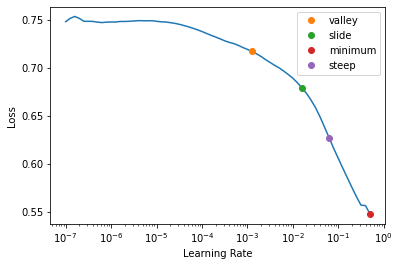

In [ ]:
learn.lr_find(start_lr=1e-07, end_lr=1000,suggest_funcs=(valley, slide, minimum, steep))

In [ ]:
learn.fit_one_cycle(epochs,lr, wd=wd)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.469378,0.328888,0.929120,00:05
1,0.271902,0.188843,0.957057,00:05
2,0.211680,0.181601,0.959578,00:05
3,0.186571,0.176671,0.962401,00:05
4,0.172869,0.175805,0.962872,00:05


In [ ]:
preds, targs = learn.get_preds()


In [ ]:
dl_roc_auc_score=roc_auc_score(to_np(targs), to_np(preds[:,1]))

## DL Permutation Importance

In [ ]:
class PermutationImportance():
  "Calculate and plot the permutation importance"
  def __init__(self, learn:Learner, df=None, bs=None):
    "Initialize with a test dataframe, a learner, and a metric"
    self.learn = learn
    self.df = df if df is not None else None
    bs = bs if bs is not None else learn.dls.bs
    self.dl = learn.dls.test_dl(self.df, bs=bs) if self.df is not None else learn.dls[1]
    self.x_names = learn.dls.x_names.filter(lambda x: '_na' not in x)
    self.na = learn.dls.x_names.filter(lambda x: '_na' in x)
    self.y = dls.y_names
    self.results = self.calc_feat_importance()
    self.plot_importance(self.ord_dic_to_df(self.results))

  def measure_col(self, name:str):
    "Measures change after column shuffle"
    col = [name]
    if f'{name}_na' in self.na: col.append(name)
    orig = self.dl.items[col].values
    perm = np.random.permutation(len(orig))
    self.dl.items[col] = self.dl.items[col].values[perm]
    metric = learn.validate(dl=self.dl)[1]
    self.dl.items[col] = orig
    return metric

  def calc_feat_importance(self):
    "Calculates permutation importance by shuffling a column on a percentage scale"
    print('Getting base error')
    base_error = self.learn.validate(dl=self.dl)[1]
    self.importance = {}
    pbar = progress_bar(self.x_names)
    print('Calculating Permutation Importance')
    for col in pbar:
      self.importance[col] = self.measure_col(col)
    for key, value in self.importance.items():
      self.importance[key] = (base_error-value)/base_error #this can be adjusted
    return OrderedDict(sorted(self.importance.items(), key=lambda kv: kv[1], reverse=True))

  def ord_dic_to_df(self, dict:OrderedDict):
    return pd.DataFrame([[k, v] for k, v in dict.items()], columns=['feature', 'importance'])

  def plot_importance(self, df:pd.DataFrame, limit=30, asc=False, **kwargs):
    "Plot importance with an optional limit to how many variables shown"
    df_copy = df.copy()
    df_copy['feature'] = df_copy['feature'].str.slice(0,25)
    df_copy = df_copy.sort_values(by='importance', ascending=asc)[:limit].sort_values(by='importance', ascending=not(asc))
    ax = df_copy.plot.barh(x='feature', y='importance', sort_columns=True, **kwargs)
    for p in ax.patches:
      ax.annotate(f'{p.get_width():.4f}', ((p.get_width() * 1.005), p.get_y()  * 1.005))

Getting base error


Calculating Permutation Importance


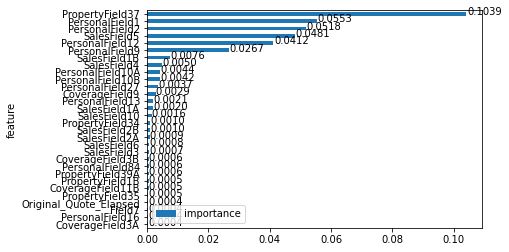

In [ ]:
imp = PermutationImportance(learn)

From this most important fields are `PropertyField37`, `PersonalField2`, `PersonalField1`, `SalesField5`

## Ensembling with Other Models

### Adding in XGBoost

In [ ]:
import xgboost as xgb


In [ ]:
n_estimators = 100
max_depth = 8
learning_rate = 0.1
subsample = 0.5

In [ ]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_valid, y_valid = to.valid.xs, to.valid.ys.values.ravel()

In [ ]:
model = xgb.XGBClassifier(n_estimators = n_estimators, max_depth=max_depth, learning_rate=0.1, subsample=subsample, tree_method='gpu_hist')

In [ ]:
xgb_model = model.fit(X_train, y_train)

In [ ]:
xgb_preds = xgb_model.predict_proba(X_valid)

In [ ]:
xg_roc_auc_score=roc_auc_score(y_valid, xgb_preds[:,1])

In [ ]:
from xgboost import plot_importance

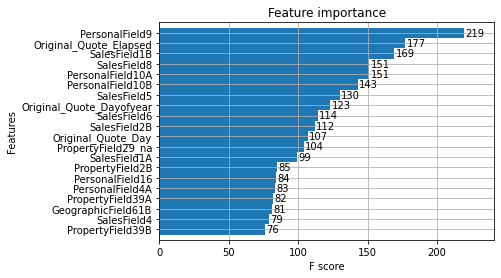

In [ ]:
plot_importance(xgb_model, height=1,max_num_features=20,)

From this most important fields were `SalesField1A`, `PersonalField9`, `Original_Quote_Elapsed`, `PersonalField10A`, `PersonalField10B`, `PropertyField37`

### Doing Ensemble

In [ ]:
avgs = (preds + xgb_preds) / 2

In [ ]:
dl_roc_auc_score

0.9628720530182229

In [ ]:
xg_roc_auc_score

0.9641320936530293

In [ ]:
dlxg_roc_auc_score=roc_auc_score(y_valid, avgs[:,1])
dlxg_roc_auc_score

0.9649946158658301

So we have a slightly better performance with ensembling these two

### Adding Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
tree = RandomForestClassifier(n_estimators=100)

In [ ]:
tree.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
!pip install rfpimp
from rfpimp import *

In [ ]:
impTree = importances(tree, X_valid, to.valid.ys)

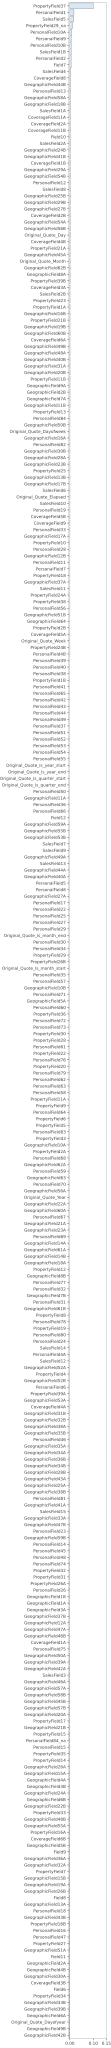

In [ ]:
plot_importances(impTree)

So here the most important are `PropertyField37`, `Field7`,`PersonalField1`, `SalesField5`, `PersonalField9`,`PersonalField2`

In [ ]:
forest_preds = tree.predict_proba(X_valid)

In [ ]:
rf_roc_auc_score=roc_auc_score(y_valid, forest_preds[:,1])
rf_roc_auc_score

0.9557626850997376

In [ ]:
new_avgs =  (preds + xgb_preds + forest_preds) / 3

In [ ]:
dlxg_roc_auc_score

0.9649946158658301

In [ ]:
dlxgrf_roc_auc_score=roc_auc_score(y_valid, new_avgs[:,1])
dlxgrf_roc_auc_score

0.9642387694379251

So it gets slightly worse when we add Random Forest to the ensemble.

## Bayesian Optimisation

There are 4 common methods of hyperparameter optimisation for machine learning: 
- **Manual** - Manually test every single hyperparameter combination
- **Grid Search** - Set up a grid of model hyperparameters and run an automatic loop through every single scenario
- **Random Search** - Similar to Grid Search but Random
- **Bayesian Optimisation**

The biggest difference between Grid Search, Random Search and Bayesian Opt is the formers do not take into account past evaluations while the later does.

There is a whole field of research dedicated to this particular optimisation method. So if you want to understand the mathematical or statistical formulas behind this model, I would suggest to read a book about it. 

But simply put, Bayesian Optimisation search builds a probability model of the objective function and use it to select the most promising hyperparameters to evaluate in the true objective function:

1. **Build a surrogate probability model of the objective function**
2. **Find the hyperparameters that perform best on the surrogate**
3. **Apply these hyperparameters to the true objective function**
4. **Update the surrogate model incorporating the new results**
5. **Repeat steps 2–4 until max iterations or time is reached**

Reference: https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f

You can easilly install a Bayesian Optimisation Python libary

In [ ]:
pip install bayesian-optimization

In [ ]:
from bayes_opt import BayesianOptimization


Define a objective function to optimise. In this case, we are going to test out learning rate, embedding dropout rate, number of layers and layer sizes.

In [ ]:
def fit_with(lr:float, wd:float, dp:float, n_layers:float, layer_1:float, layer_2:float, layer_3:float):

    print(lr, wd, dp)
    if round(n_layers) == 2:
        layers = [round(layer_1), round(layer_2)]
    elif int(n_layers) == 3:
        layers = [round(layer_1), round(layer_2), round(layer_3)]
    else:
        layers = [round(layer_1)]
    config = tabular_config(embed_p=float(dp),
                          ps=float(wd))
    learn = tabular_learner(dls, layers=layers, metrics=roc_auc_binary, config = config)

    with learn.no_bar() and learn.no_logging():
        learn.fit(5, lr=float(lr))

    preds, targs = learn.get_preds()
    auc_score = roc_auc_score(to_np(targs), to_np(preds[:,1]))

    return auc_score

We can also specify a range of values for each hyperparameter that we want to tune.

In [ ]:
hps = {'lr': (1e-05, 1e-01),
      'wd': (4e-4, 0.4),
      'dp': (0.01, 0.5),
       'n_layers': (1,3),
       'layer_1': (50, 200),
       'layer_2': (100, 1000),
       'layer_3': (200, 2000)}


In [ ]:
optim = BayesianOptimization(
    f = fit_with, # our fit function
    pbounds = hps, # our hyper parameters to tune
    verbose = 2, # 1 prints out when a maximum is observed, 0 for silent, 2 prints out everything
    random_state=1
)

In [ ]:
%time optim.maximize(n_iter=10)


|   iter    |  target   |    dp     |  layer_1  |  layer_2  |  layer_3  |    lr     | n_layers  |    wd     |
-------------------------------------------------------------------------------------------------------------
0.014684121522803134 0.07482958046651729 0.21434078230426126


|  1        |  0.9603   |  0.2143   |  158.0    |  100.1    |  744.2    |  0.01468  |  1.185    |  0.07483  |
0.06852509784467198 0.3512957275818218 0.1793247562510934


|  2        |  0.9602   |  0.1793   |  109.5    |  584.9    |  954.6    |  0.06853  |  1.409    |  0.3513   |
0.014047289990137426 0.32037752964274446 0.02341992066698382


|  3        |  0.9611   |  0.02342  |  150.6    |  475.6    |  1.206e+0 |  0.01405  |  1.396    |  0.3204   |
0.0894617202837497 0.016006291379859792 0.4844481721025048


|  4        |  0.9574   |  0.4844   |  97.01    |  723.1    |  1.778e+0 |  0.08946  |  1.17     |  0.01601  |
0.0957893741197487 0.27687409473460917 0.09321690558663875


|  5        |  0.9599   |  0.09322  |  181.7    |  188.5    |  958.0    |  0.09579  |  2.066    |  0.2769   |
0.010278165724320144 0.09525641811550664 0.039180893394315415


|  6        |  0.9612   |  0.03918  |  169.8    |  995.0    |  206.4    |  0.01028  |  1.351    |  0.09526  |
0.07156047620301159 0.271888626159136 0.3620644418259379


|  7        |  0.9588   |  0.3621   |  50.52    |  104.8    |  244.5    |  0.07156  |  1.178    |  0.2719   |
0.057910440131609765 0.16129406478624328 0.4828208474809104


|  8        |  0.9592   |  0.4828   |  59.94    |  147.0    |  1.301e+0 |  0.05791  |  2.722    |  0.1613   |
0.02154668435098685 0.2935334962486139 0.17485814792145116


|  9        |  0.962    |  0.1749   |  196.0    |  957.2    |  214.1    |  0.02155  |  1.024    |  0.2935   |
0.03610993906058106 0.3546354028405215 0.12958547535553333


|  10       |  0.9614   |  0.1296   |  197.9    |  133.6    |  209.7    |  0.03611  |  2.237    |  0.3546   |
0.07160071668964274 0.11955317037046867 0.30174764680544724


|  11       |  0.9594   |  0.3017   |  196.8    |  972.1    |  263.6    |  0.0716   |  1.003    |  0.1196   |
0.0758754095037137 0.26350352166402036 0.10013698396219092


|  12       |  0.9595   |  0.1001   |  195.5    |  166.4    |  236.0    |  0.07588  |  1.276    |  0.2635   |
0.08706685388671734 0.2815475542319707 0.0263005243239511


|  13       |  0.9594   |  0.0263   |  199.1    |  990.5    |  1.991e+0 |  0.08707  |  2.941    |  0.2815   |
0.05628262681087503 0.1085257299138718 0.26772478114338355


|  14       |  0.9609   |  0.2677   |  152.2    |  105.5    |  755.5    |  0.05628  |  2.52     |  0.1085   |
0.0808374555333798 0.18564863221735886 0.2417705717996151


|  15       |  0.9596   |  0.2418   |  199.4    |  125.6    |  235.7    |  0.08084  |  1.814    |  0.1856   |
CPU times: user 7min 40s, sys: 8.93 s, total: 7min 49s
Wall time: 7min 40s


Print out the set of hyperparameters that produce the best accuracy score and use them to train our deep learning model again

In [ ]:
print(optim.max)


{'target': 0.9619591011409044, 'params': {'dp': 0.17485814792145116, 'layer_1': 196.0396513158857, 'layer_2': 957.170989722186, 'layer_3': 214.1299530803173, 'lr': 0.02154668435098685, 'n_layers': 1.023739458890539, 'wd': 0.2935334962486139}}


In [ ]:
random_seed = 42 
bs = 4096
val_bs = 512
test_size = 0.3
epochs = 5
lr = 0.02 #0.03
wd=0.3 #0.32
layers = [200] #200,150[50,1000]
dropout = [0.001, 0.01]
y_block=CategoryBlock()
emb_dropout=0.17 #0.13 #0.2
set_seed(42)
roc_auc_binary = RocAucBinary()

In [ ]:
dls = to.dataloaders(bs=bs, val_bs=val_bs, layers=layers, embed_ps=emb_dropout, ps=dropout)

In [ ]:
learn = tabular_learner(dls, metrics=roc_auc_binary)

In [ ]:
learn.fit_one_cycle(6,lr, wd=wd)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.436900,0.235703,0.947294,00:05
1,0.260621,0.191002,0.959327,00:05
2,0.210429,0.185707,0.959293,00:05
3,0.187610,0.176735,0.962208,00:05
4,0.174427,0.174023,0.963673,00:05
5,0.164969,0.174370,0.963667,00:05


In [ ]:
preds, targs = learn.get_preds()

In [ ]:
dl_opt_roc_au_score = roc_auc_score(to_np(targs), to_np(preds[:,1]))
dl_roc_auc_score, dl_opt_roc_au_score


(0.9628720530182229, 0.963667492106761)

The final roc_au_score increases from 0.962 to 0.963, which is quite significant for this particular dataset. Because if you have a look at the Kaggle Leaderboard, the accuracy score starts at around 0.95 and the highest score is around 0.97

## Entity Embeddings

The most common variable types in structured data are:

1. continuous variables 
2. categorical variables

To use cat variables in our model, we need to represent them as integers. 
 

Sometimes, there are intrinsic ordering in those numbers (for example: low - 1, medium - 2, high - 3) and they are called ordinal numbers. 

But more than often, those integers are random and don’t provide any information and they are called nominal numbers. For example, sex or states (we cannot really rank states).

Our model will perform better if those integers contain some relevant information of that paticular cat variable.

One way to deal with this problem is to use one hot end coding. But the issue with one hot end coding is that it is computationally expensive.

What entity embeddings can do is putting similar values of a cat variable closer together in the embedding space. You can first train a neural network with cat embeddings and then use those cat embeddings instead of raw categorical columns in the models. 

In [ ]:
learn.model.embeds

ModuleList(
  (0): Embedding(9, 5)
  (1): Embedding(9, 5)
  (2): Embedding(3, 3)
  (3): Embedding(4, 3)
  (4): Embedding(5, 4)
  (5): Embedding(4, 3)
  (6): Embedding(5, 4)
  (7): Embedding(8, 5)
  (8): Embedding(13, 7)
  (9): Embedding(3, 3)
  (10): Embedding(6, 4)
  (11): Embedding(6, 4)
  (12): Embedding(8, 5)
  (13): Embedding(3, 3)
  (14): Embedding(18, 8)
  (15): Embedding(19, 8)
  (16): Embedding(9, 5)
  (17): Embedding(11, 6)
  (18): Embedding(12, 6)
  (19): Embedding(3, 3)
  (20): Embedding(3, 3)
  (21): Embedding(10, 6)
  (22): Embedding(3, 3)
  (23): Embedding(3, 3)
  (24): Embedding(4, 3)
  (25): Embedding(4, 3)
  (26): Embedding(6, 4)
  (27): Embedding(6, 4)
  (28): Embedding(5, 4)
  (29): Embedding(51, 14)
  (30): Embedding(67, 17)
  (31): Embedding(62, 16)
  (32): Embedding(58, 16)
  (33): Embedding(8, 5)
  (34): Embedding(13, 7)
  (35): Embedding(13, 7)
  (36): Embedding(13, 7)
  (37): Embedding(14, 7)
  (38): Embedding(17, 8)
  (39): Embedding(8, 5)
  (40): Embedding(8

Function to embed features, obtained from Fastai forums


In [ ]:
def embed_features(learner, xs):
    xs = xs.copy()
    for i, feature in enumerate(learner.dls.cat_names):
        emb = learner.model.embeds[i]
        new_feat = pd.DataFrame(emb(tensor(xs[feature], dtype=torch.int32).to('cuda:0')), index=xs.index, columns=[f'{feature}_{j}' for j in range(emb.embedding_dim)])
        xs.drop(columns=feature, inplace=True)
        xs = xs.join(new_feat)
    return xs


Run this function for both your training and valid sets

In [ ]:
emb_xs = embed_features(learn, to.train.xs)


In [ ]:
emb_valid_xs = embed_features(learn, to.valid.xs)


Use the embedded layers to train your gradient boosting model

In [ ]:
model = xgb.XGBClassifier(n_estimators = n_estimators, max_depth=max_depth, learning_rate=0.1, subsample=subsample, tree_method='gpu_hist')

In [ ]:
xgb_model_emb=model.fit(emb_xs, y_train)

In [ ]:
xgb_emb_preds = xgb_model_emb.predict_proba(emb_valid_xs)

In [ ]:
xg_emb_roc_auc_score=roc_auc_score(y_valid, xgb_emb_preds[:,1])
xg_roc_auc_score, xg_emb_roc_auc_score

(0.9641320936530293, 0.9640538678190417)

In this problem, it doesn't seem to change the accuracy score. However, you might be more sucessful with other datasets. 